# Problem Statement

---


Chronic Kidney Disease (CKD) often progresses without noticeable symptoms until advanced stages, making early detection critical. Traditional diagnosis methods can be time-consuming and inaccessible in many regions. With increasing availability of clinical data, there is a need for an accurate, interpretable, and easily deployable ML-based tool to assist in early CKD detection.

# Objectives  


---


**Aim**  
To develop a machine learning-based system for the early prediction of Chronic Kidney Disease (CKD) using patient clinical and laboratory data.

**Data Source**  
The dataset used was obtained from Kaggle, containing 400 records with 26 features, including both numerical and categorical attributes related to kidney function.

**Goals**  
1. Preprocess and clean the dataset to handle missing values and convert categorical data.

2. Perform Exploratory Data Analysis (EDA) to understand feature relationships.

3. Train and compare various classification models (e.g., Logistic Regression, Random Forest, XGBoost).

4. Evaluate models using appropriate metrics such as accuracy, precision, recall, and F1-score.

5. Select the most accurate and generalizable model for deployment.  

**Deployment**  
- Deploy the selected model using Flask, creating a lightweight web interface.

- Allow users to input clinical data and receive real-time CKD predictions.

- Make the system intuitive and accessible for use in medical decision support.

In [1]:
# Step 1: Imports and setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
# Step 2: Load and preview data

df = pd.read_csv('kidney_disease.csv')
df.drop('id', axis=1, inplace=True)

# Renaming columns for clarity
df.columns = ['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar', 'red_blood_cells', 'pus_cell',
              'pus_cell_clumps', 'bacteria', 'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
              'potassium', 'haemoglobin', 'packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count',
              'hypertension', 'diabetes_mellitus', 'coronary_artery_disease', 'appetite', 'peda_edema',
              'aanemia', 'class']

# Preview dataset
display(df.head())
print(df.shape)
df.describe()

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,aanemia,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35,7300,4.6,no,no,no,good,no,no,ckd


(400, 25)


,age,blood_pressure,specific_gravity,albumin,sugar,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,haemoglobin
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000


In [3]:
# Step 3: Explore data (EDA)

df.info()

# Convert object numerics to proper dtype
df['packed_cell_volume'] = pd.to_numeric(df['packed_cell_volume'], errors='coerce')
df['white_blood_cell_count'] = pd.to_numeric(df['white_blood_cell_count'], errors='coerce')
df['red_blood_cell_count'] = pd.to_numeric(df['red_blood_cell_count'], errors='coerce')

cat_cols = [col for col in df.columns if df[col].dtype == 'object']
num_cols = [col for col in df.columns if df[col].dtype != 'object']

for col in cat_cols:
    print(f"{col} → {df[col].unique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      391 non-null    float64
 1   blood_pressure           388 non-null    float64
 2   specific_gravity         353 non-null    float64
 3   albumin                  354 non-null    float64
 4   sugar                    351 non-null    float64
 5   red_blood_cells          248 non-null    object 
 6   pus_cell                 335 non-null    object 
 7   pus_cell_clumps          396 non-null    object 
 8   bacteria                 396 non-null    object 
 9   blood_glucose_random     356 non-null    float64
 10  blood_urea               381 non-null    float64
 11  serum_creatinine         383 non-null    float64
 12  sodium                   313 non-null    float64
 13  potassium                312 non-null    float64
 14  haemoglobin              3

In [4]:
# Step 4: Clean data

df['diabetes_mellitus'].replace({'\\tno': 'no', '\\tyes': 'yes', ' yes': 'yes'}, inplace=True)
df['coronary_artery_disease'].replace('\\tno', 'no', inplace=True)
df['class'].replace({'ckd\\t': 'ckd', 'notckd': 'not ckd'}, inplace=True)
df['class'] = df['class'].map({'ckd': 0, 'not ckd': 1})
df['class'] = pd.to_numeric(df['class'], errors='coerce')

# Show fixed unique values
for col in ['diabetes_mellitus', 'coronary_artery_disease', 'class']:
    print(f"{col} → {df[col].unique()}")

diabetes_mellitus → ['yes' 'no' '\tno' '\tyes' nan]
coronary_artery_disease → ['no' 'yes' '\tno' nan]
class → [ 0. nan  1.]


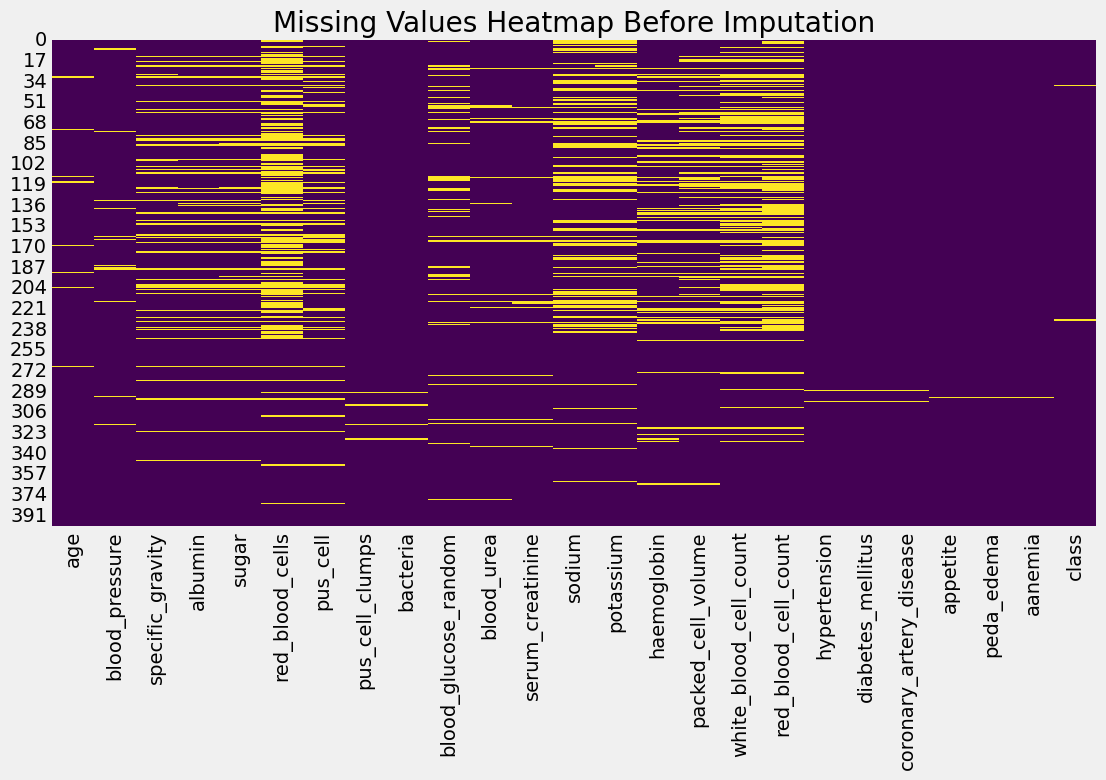

In [5]:
# Visualize missing values before imputation
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap Before Imputation')
plt.show()


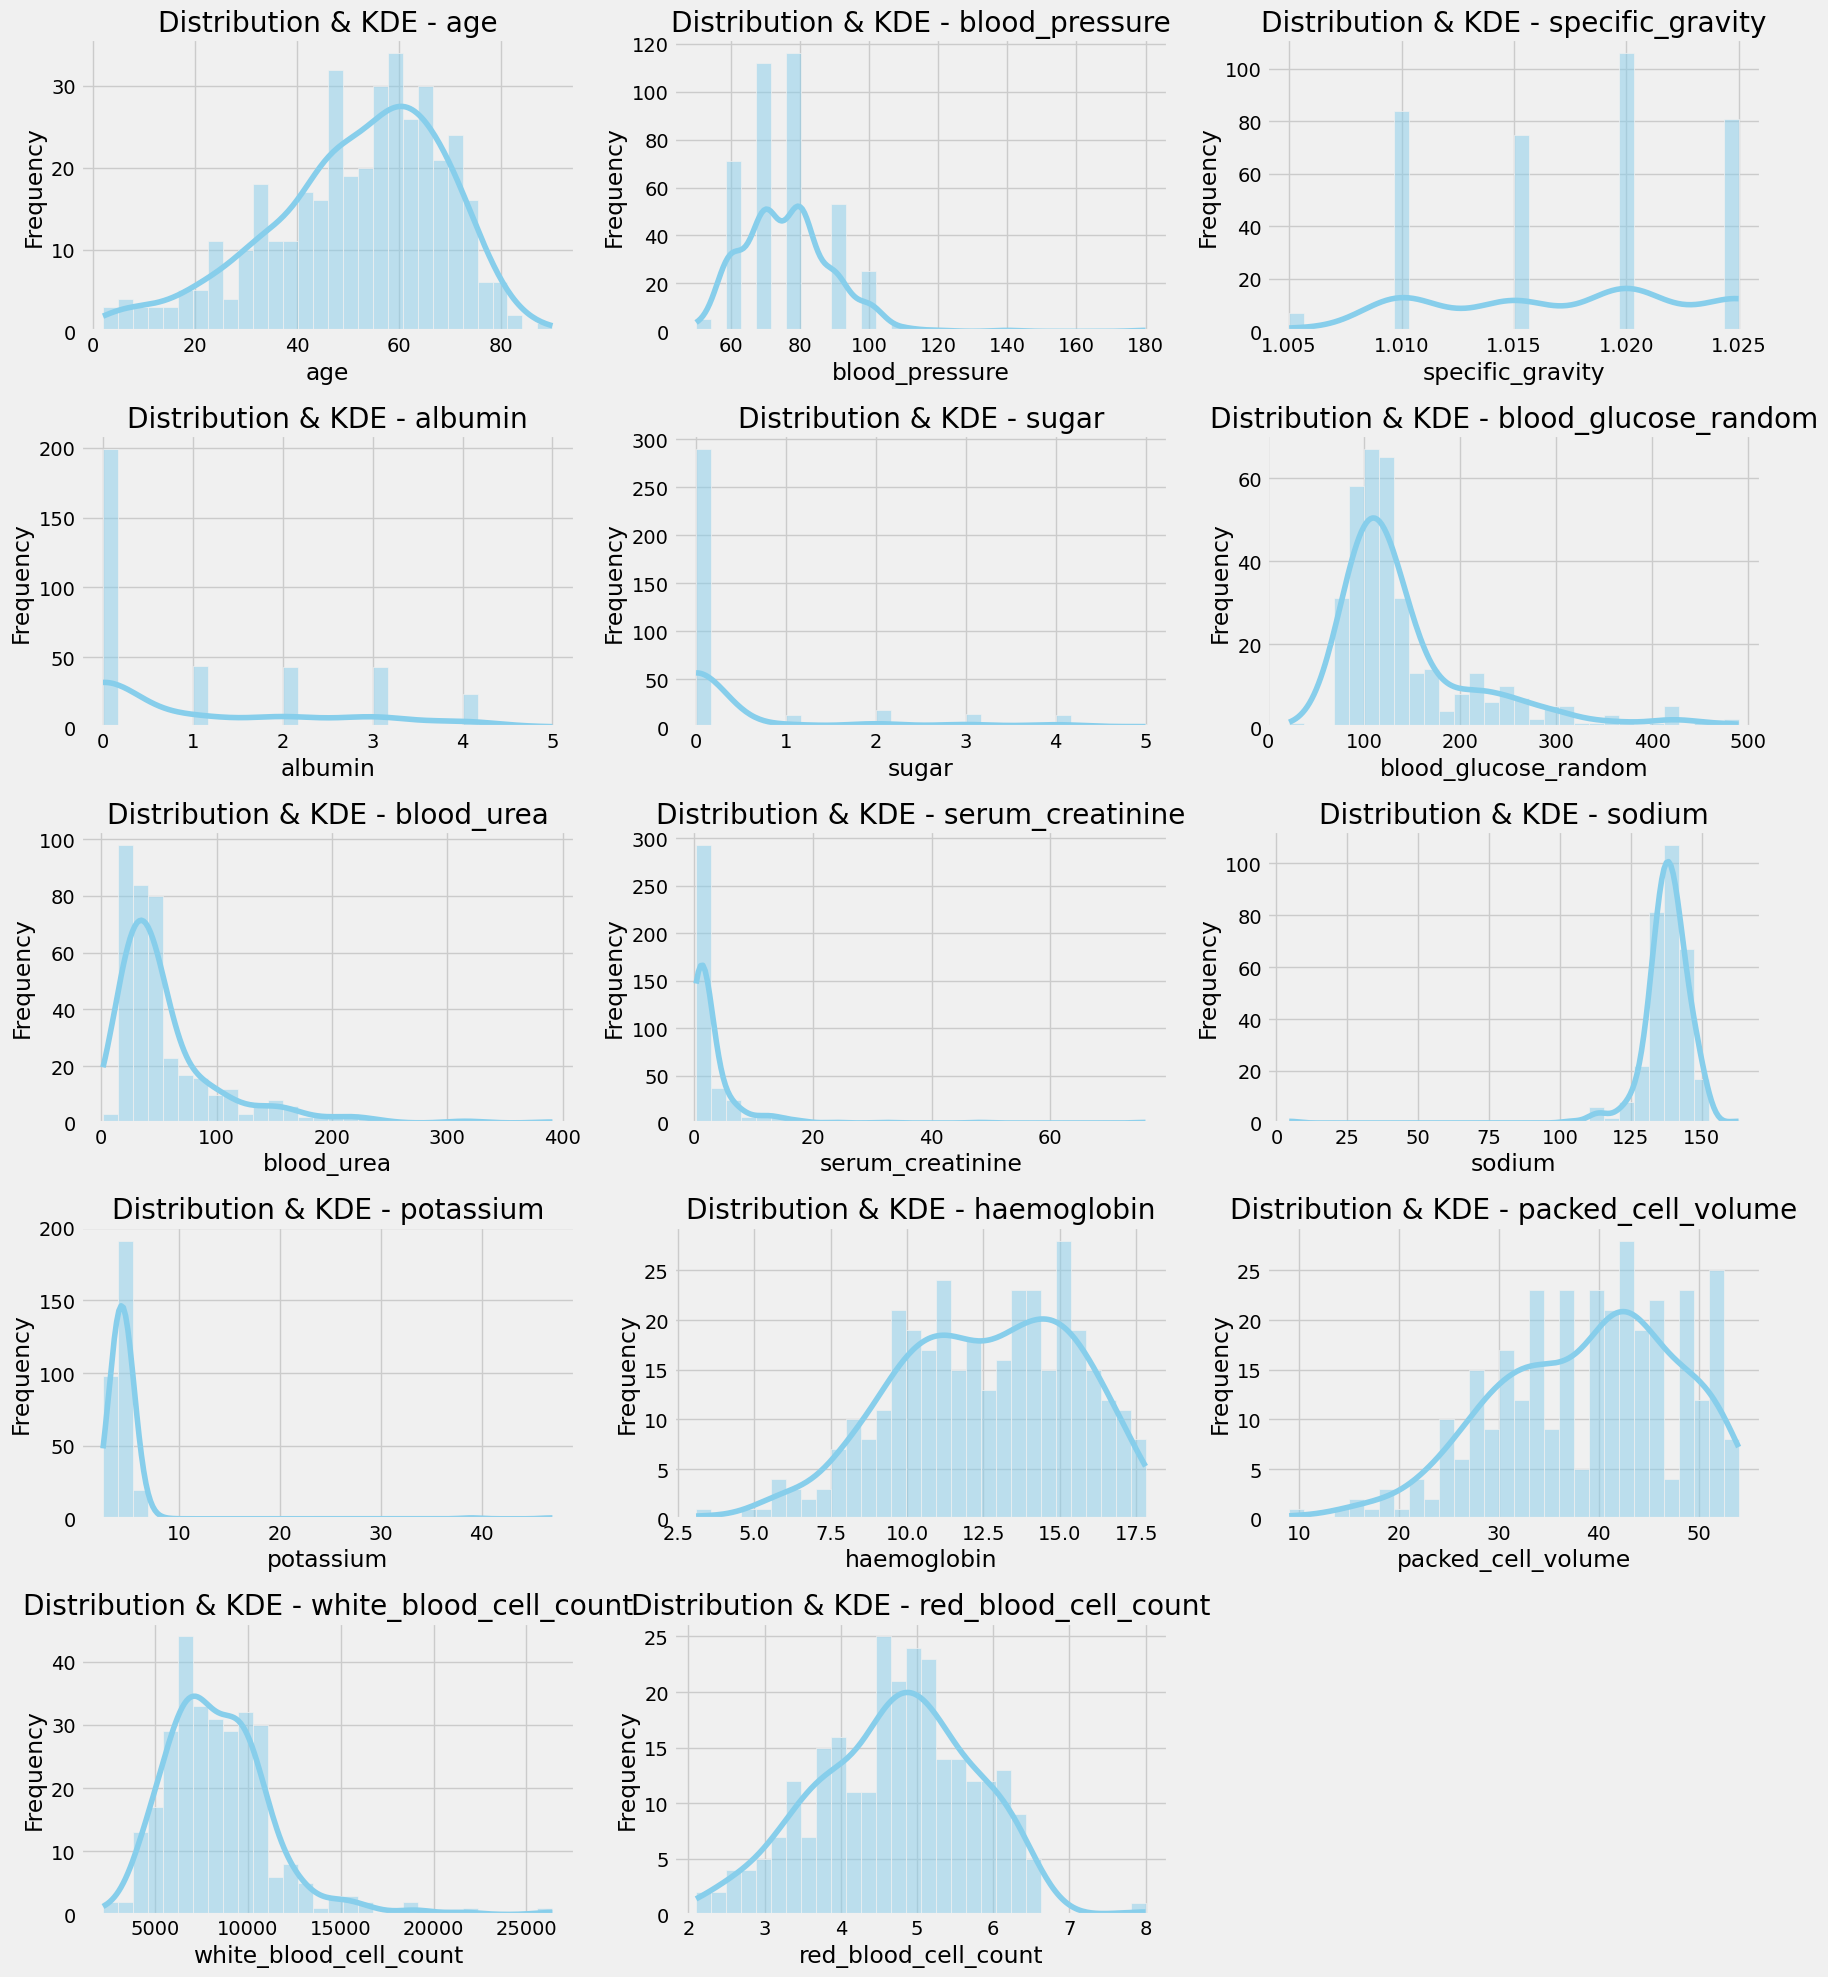

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify numeric columns excluding target/class
num_cols = [col for col in df.columns if df[col].dtype != 'object' and col != 'class']

# Set number of rows and columns for subplots
n_cols = 3  # adjust as needed
n_rows = (len(num_cols) + n_cols - 1) // n_cols

# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
axes = axes.flatten()

# Plot each numeric column
for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, bins=30, color='skyblue', ax=axes[i])
    axes[i].set_title(f'Distribution & KDE - {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

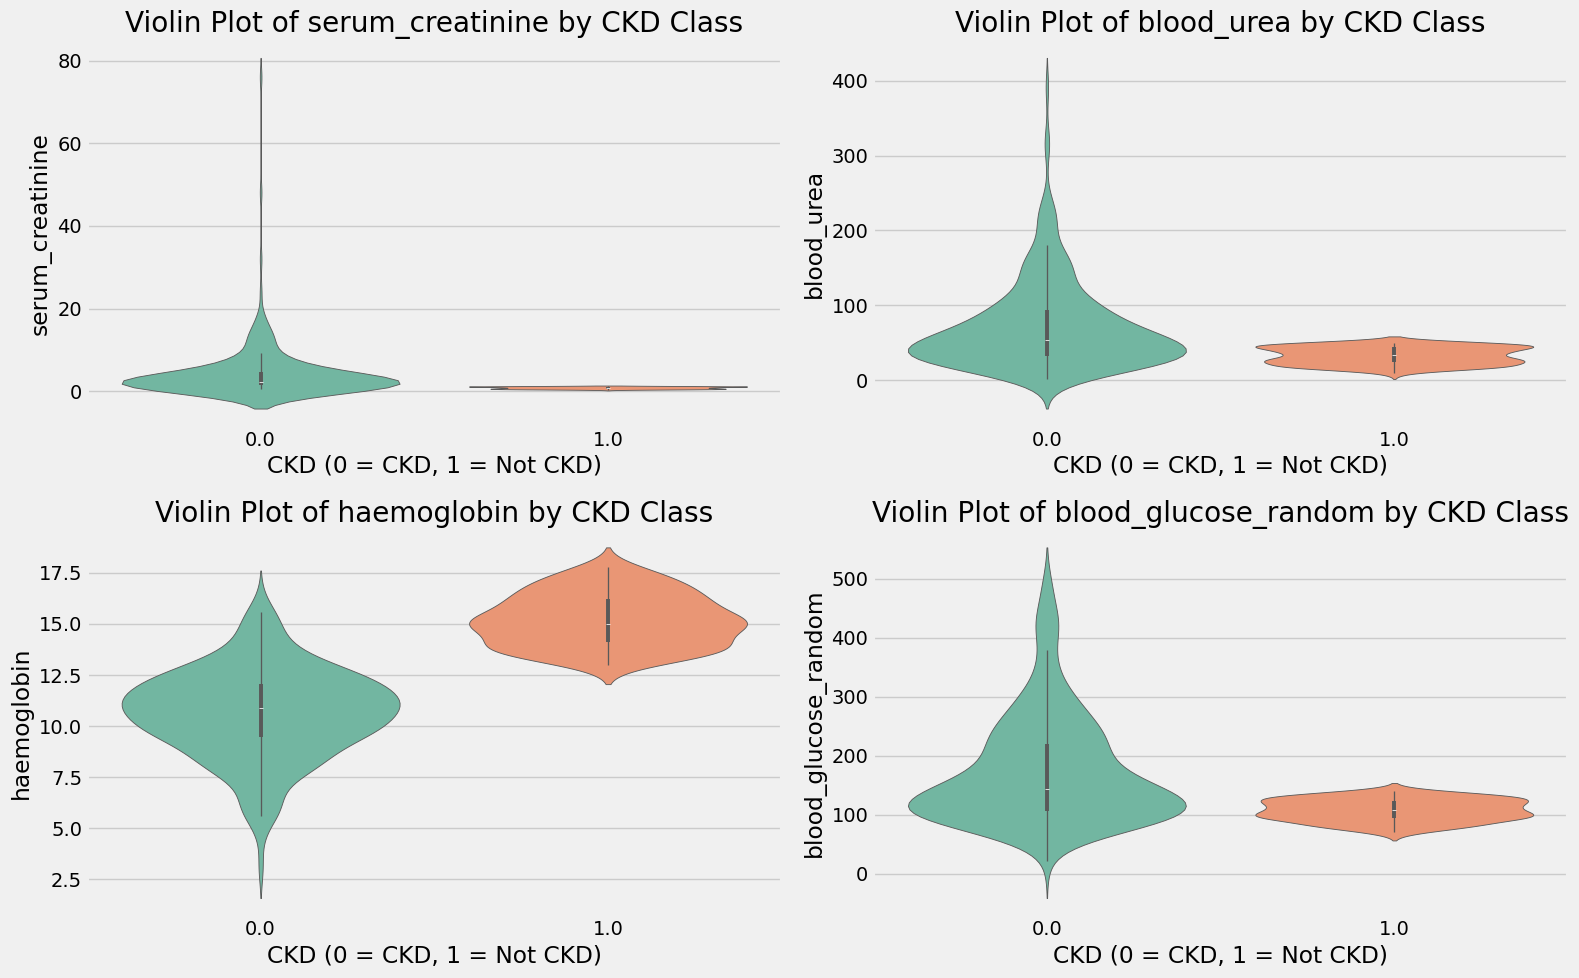

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Features to plot
violin_features = ['serum_creatinine', 'blood_urea', 'haemoglobin', 'blood_glucose_random']

# Set up 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))  # (rows, cols)
axes = axes.flatten()

# Plot each violin plot
for i, col in enumerate(violin_features):
    sns.violinplot(data=df, x='class', y=col, palette='Set2', ax=axes[i])
    axes[i].set_title(f'Violin Plot of {col} by CKD Class')
    axes[i].set_xlabel('CKD (0 = CKD, 1 = Not CKD)')
    axes[i].set_ylabel(col)

# Adjust layout and show
plt.tight_layout()
plt.show()


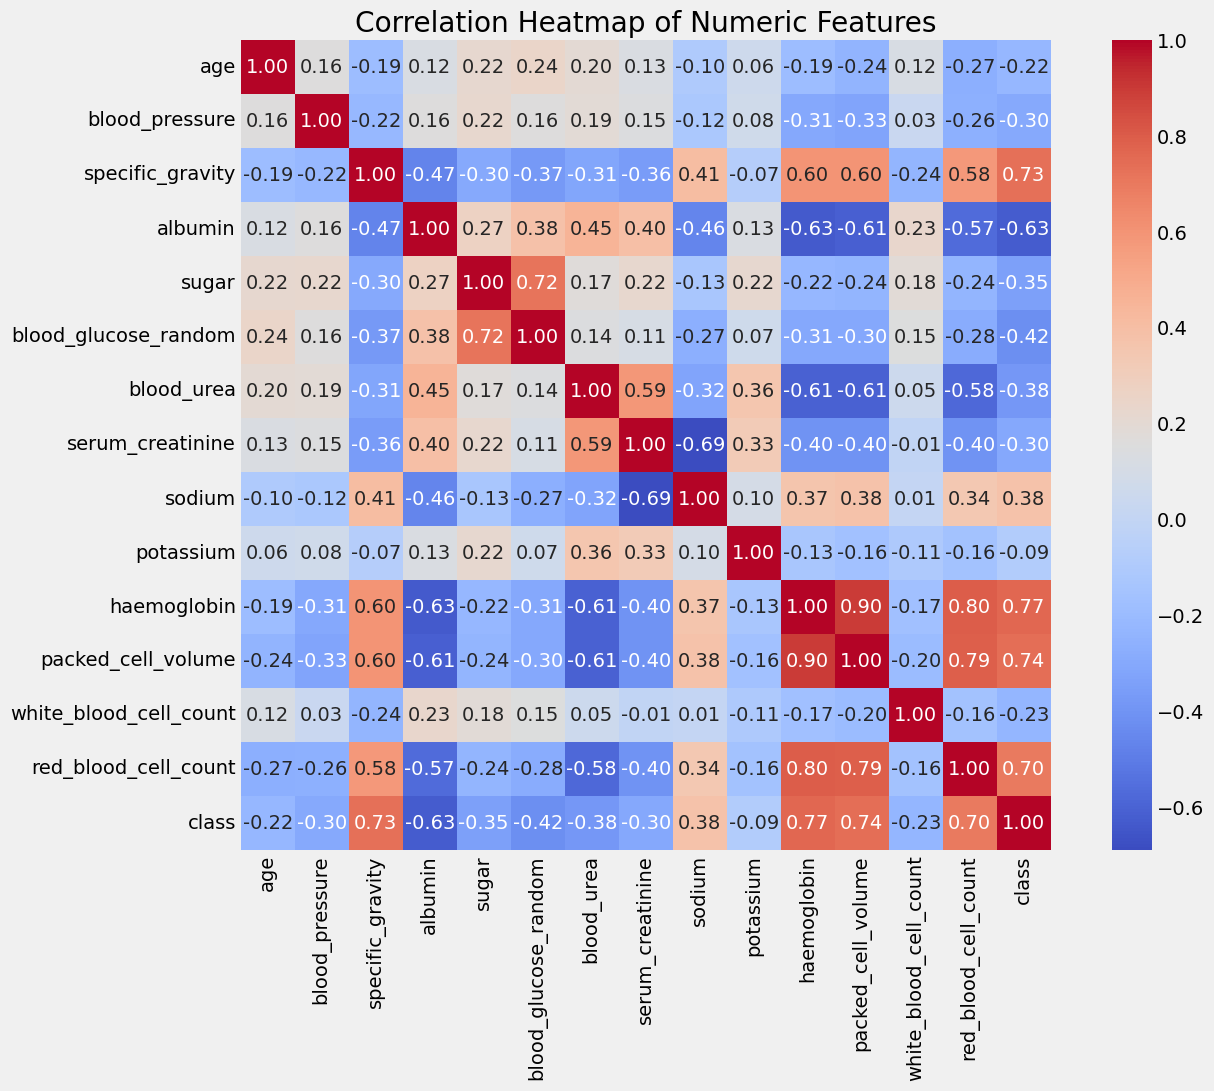

In [8]:
# Correlation heatmap for numeric features only
numeric_df = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(14, 10))
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


In [9]:
# Step 5: Feature Engineering (handle missing & encoding)


def random_value_imputation(feature):
    random_sample = df[feature].dropna().sample(df[feature].isna().sum())
    random_sample.index = df[df[feature].isnull()].index
    df.loc[df[feature].isnull(), feature] = random_sample

def impute_mode(feature):
    mode = df[feature].mode()[0]
    df[feature].fillna(mode, inplace=True)

# Impute numerical
for col in num_cols:
    random_value_imputation(col)

# Impute specific categoricals randomly
random_value_imputation('red_blood_cells')
random_value_imputation('pus_cell')

# Remaining categoricals use mode
for col in cat_cols:
    impute_mode(col)

# Label encode all categoricals
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Final check
df.isnull().sum().sum(), df.head()

(0,
     age  blood_pressure  specific_gravity  albumin  sugar  red_blood_cells  \
 0  48.0            80.0             1.020      1.0    0.0                1   
 1   7.0            50.0             1.020      4.0    0.0                1   
 2  62.0            80.0             1.010      2.0    3.0                1   
 3  48.0            70.0             1.005      4.0    0.0                1   
 4  51.0            80.0             1.010      2.0    0.0                1   
 
    pus_cell  pus_cell_clumps  bacteria  blood_glucose_random  ...  \
 0         1                0         0                 121.0  ...   
 1         1                0         0                  99.0  ...   
 2         1                0         0                 423.0  ...   
 3         0                1         0                 117.0  ...   
 4         1                0         0                 106.0  ...   
 
    packed_cell_volume  white_blood_cell_count  red_blood_cell_count  \
 0                44.0    

In [10]:
# Step 6: Split data

X = df.drop('class', axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [11]:
# Step 7: Train model

xgb = XGBClassifier(objective='binary:logistic', learning_rate=0.5, max_depth=5, n_estimators=150)
xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,use_label_encoder,None
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [12]:
# Step 8: Evaluate model

y_pred = xgb.predict(X_test)

print("✅ Training Accuracy:", accuracy_score(y_train, xgb.predict(X_train)))
print("✅ Test Accuracy:", accuracy_score(y_test, y_pred))
print("\\n📊 Confusion Matrix:\\n", confusion_matrix(y_test, y_pred))
print("\\n📋 Classification Report:\\n", classification_report(y_test, y_pred))

✅ Training Accuracy: 1.0
✅ Test Accuracy: 0.9916666666666667
\n📊 Confusion Matrix:\n [[72  0]
 [ 1 47]]
\n📋 Classification Report:\n               precision    recall  f1-score   support

           0       0.99      1.00      0.99        72
           1       1.00      0.98      0.99        48

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



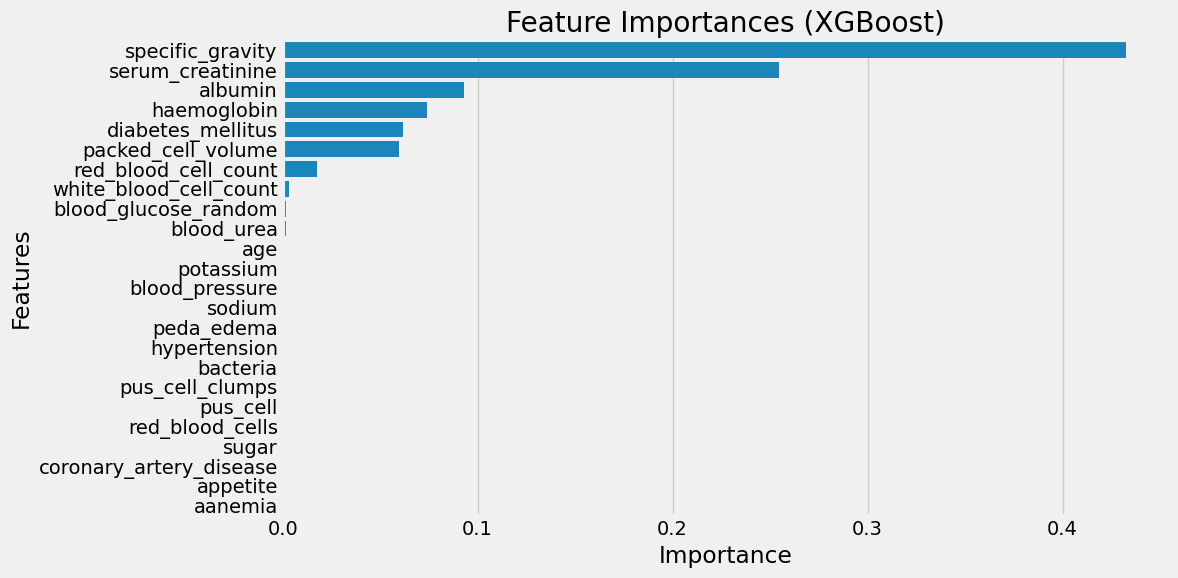

In [13]:
# Step 9: Feature Importance

importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title("Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [16]:
import joblib

# Save the trained XGBoost model
joblib.dump(xgb, 'app/model/xgboost_ckd_model.pkl')
print("✅ Model saved successfully.")

✅ Model saved successfully.
